This is a notebook that computes and scans model C.
It uses a evenly spaced grid

# Init

In [1]:
from __future__ import division

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../')

In [4]:
import numpy as np
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.integrate import quad
import h5py
import glob
import re
import os

import scan
import pickle
import glob
from multiprocessing import Pool
from contextlib import closing

from matplotlib import cm
from tqdm import tqdm

from multiprocessing import Pool
from contextlib import closing
from scipy.optimize import root_scalar

In [5]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import spc
import model
import chi2
import margin

In [6]:
from matplotlib import rcParams
#rcParams["font.family"] = "Times New Roman"
rcParams['font.size'] = 14

In [7]:
path = '../data/SPARC.txt'
data = spc.readSPARC(path)

path = '../data/SPARC_Lelli2016c.txt'
spc.readSPARC_ext(data, path)

In [8]:
data2 = {}
for gal in data:
    data2[gal.name] = gal

# Scan on one galaxy, a demo

In [9]:
ups_low = 0.
ups_high = 5.
log_M_low = 5.
log_M_high = 11.
log_m_low = -24
log_m_high = -19

ups_disk_arr = np.linspace(ups_low, ups_high, 20)
ups_bulg_arr = np.linspace(ups_low, ups_high, 20)
log_M_arr = np.linspace(log_M_low, log_M_high, 30)
log_m_arr = np.linspace(log_m_low, log_m_high, 20)

ups_disk_mesh, ups_bulg_mesh = np.meshgrid(ups_disk_arr, ups_bulg_arr)

ups_disk_flat = ups_disk_mesh.reshape(-1)
ups_bulg_flat = ups_bulg_mesh.reshape(-1) 
#log_M_flat = log_M_mesh.reshape(-1)

In [10]:
gal = spc.findGalaxyByName('UGC01281', data)
gal.name

'UGC01281'

In [11]:
res_arr = []
for log_m in log_m_arr:
    
    m = 10**log_m
    chi2_arr = np.asarray([1e10]*len(log_M_arr))

    # for each M value, minimizes over Ups
    for j in range(len(log_M_arr)):
        M = 10**log_M_arr[j]
        for i in range(len(ups_disk_flat)):
            ups_disk = ups_disk_flat[i]
            ups_bulg = ups_bulg_flat[i]
            chi2_val = chi2.chi2_single_gal_overshooting(m=m, M=M, ups_disk=ups_disk, ups_bulg=ups_bulg, gal=gal)
            chi2_arr[j] = min(chi2_arr[j], chi2_val)
            
    result = scan.Result(log_m)
    result.chi2_arr = chi2_arr
    result.M_arr = 10**log_M_arr
    
    # sanity check
    result.check_chi_min()
    
    # save it
    res_arr.append(result)
    

<IPython.core.display.Javascript object>


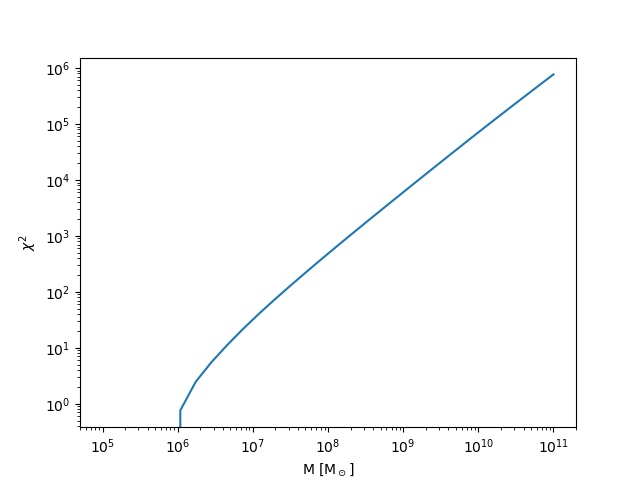

Text(0,0.5,'$\\chi^2$')

In [12]:
plt.subplots()
plt.plot(10**log_M_arr, chi2_arr)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('M [M$_\odot$]')
plt.ylabel('$\chi^2$')

In [13]:
scan.analyze(res_arr, [1,2,3,4,5,10])
# this will generate 1, 2, 3, 4, 5, 10 sigmas 
# and save it into result.M_contours

<IPython.core.display.Javascript object>


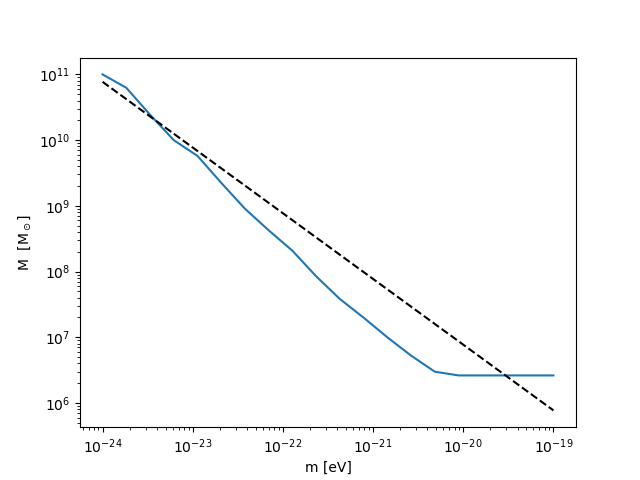

Text(0,0.5,'M  [M$_\\odot$]')

In [15]:
plt.subplots()

m_plt_arr = []
M_plt_arr = []
for result in res_arr:
    m = result.m
    M = result.M_contours[4]
    m_plt_arr.append(m)
    M_plt_arr.append(M)

# the bound
plt.plot(m_plt_arr, M_plt_arr)
# the SH prediction
Msol_SH_arr = model.M_SH(m_plt_arr, gal)
plt.plot(m_plt_arr, Msol_SH_arr, 'k--')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M  [M$_\odot$]')

<IPython.core.display.Javascript object>


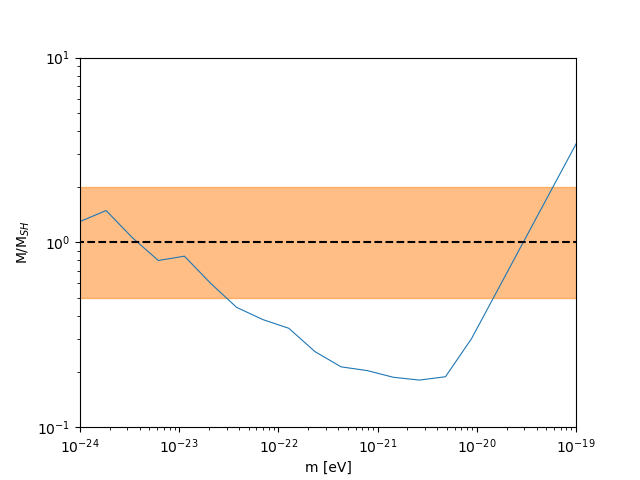

(1e-24, 1e-19)

In [16]:
# ratio plot

plt.subplots()

m_plt_arr = []
M_plt_arr = []
for result in res_arr:
    m = result.m
    M = result.M_contours[4]
    m_plt_arr.append(m)
    M_plt_arr.append(M)

# the bound
Msol_SH_arr = model.M_SH(m_plt_arr, gal)
plt.plot(m_plt_arr, M_plt_arr/ Msol_SH_arr, lw='0.8')

# the SH prediction
x = np.logspace(-25, -18)
y = [1] * 50
ylow = [0.5] * 50
yup = [2] * 50
plt.fill_between(x, ylow, yup, alpha=0.5, color='C1')
plt.plot(x, y, 'k--')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M/M$_{SH}$')
plt.ylim(0.1, 10)
plt.xlim(1e-24, 1e-19)

In [64]:
# save instance to file
uid = np.random.randint(1e10)
path = '../results/result-%d.dat' %uid

with open(path, 'w') as f:
    pickle.dump(result, f)

##load with
# with open(path, 'r') as f:
#     result2 = pickle.load(f)

# Scan on one galaxy - with scan.py

In [17]:
# packaged everything into scan.scan() 
scanner = scan.Scanner()
scanner.scan(gal, 
          num_of_ups=20, 
          num_of_log_M=20, 
          num_of_log_m=5, 
          dir_name='results_test3')

100%|██████████| 5/5 [00:25<00:00,  5.14s/it]


In [ ]:
# load and plot out

<IPython.core.display.Javascript object>


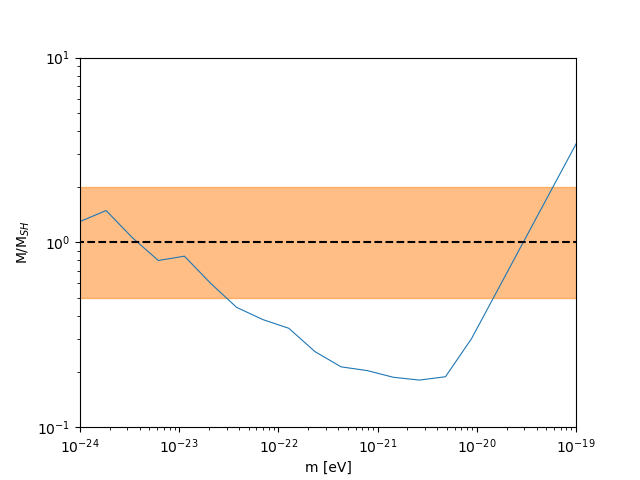

In [20]:
plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M/M$_{SH}$')
plt.ylim(0.1, 10)
plt.xlim(1e-24, 1e-19)

path_wild = '../results_test3/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    with open(path, 'r') as f:
        result= pickle.load(f)      
        m_plt_arr = []
        M_plt_arr = []
        for result in res_arr:
            m = result.m
            M = result.M_contours[4]
            m_plt_arr.append(m)
            M_plt_arr.append(M)

        # the bound
        Msol_SH_arr = model.M_SH(m_plt_arr, gal)
        plt.plot(m_plt_arr, M_plt_arr/ Msol_SH_arr, lw='0.8')

        # the SH prediction
        x = np.logspace(-25, -18)
        y = [1] * 50
        ylow = [0.5] * 50
        yup = [2] * 50
        plt.fill_between(x, ylow, yup, alpha=0.5, color='C1')
        plt.plot(x, y, 'k--')


# Scan on all SPARC - from scan.py

In [194]:
os.getcwd()

'/tomerv2/cs/BEC_dynamics/submit/notebooks'

In [9]:
scanner = scan.Scanner()

def f(gal):
    scanner.scan(gal, 
                 num_of_ups=50, #20
                 num_of_log_M=50, #20
                 num_of_log_m=50, #20
                 dir_name='results_test999')

with closing(Pool()) as pool:
    pool.map(f, data)
    pool.terminate()


  2%|▏         | 1/50 [00:53<43:23, 53.13s/it]8s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
bound_dct = {}
bound_range_dct = {}

<IPython.core.display.Javascript object>


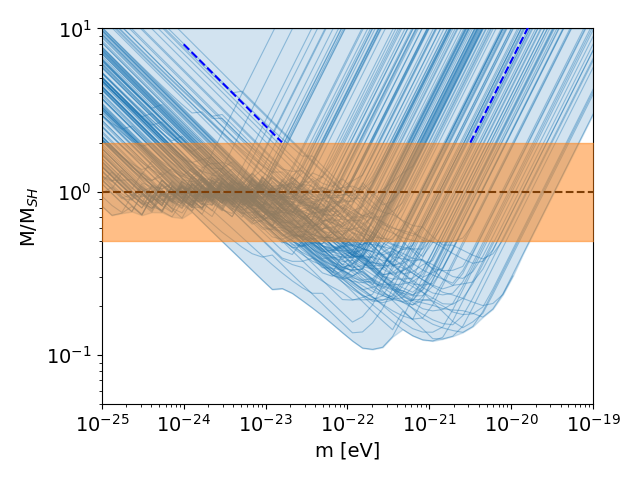

In [18]:
plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M/M$_{SH}$')
plt.ylim(0.05, 10)
#plt.xlim(2e-24, 1e-19)
plt.xlim(1e-25, 1e-19)

ratio_upper = 2
ratio_lower = 0.5

M_joint_arr = []
m_joint_arr = []
n_ind = 1

path_wild = '../../results_test11/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    with open(path, 'r') as f:
        results= pickle.load(f)      
        res_arr = results.storage
        scan.analyze(res_arr, res_arr[0].sigma_lvl)
        
        m_plt_arr = []
        M_plt_arr = []
        for result in res_arr:
            if not result.sane:
                continue            
            m = result.m
            M = result.M_contours[n_ind]
            m_plt_arr.append(m)
            M_plt_arr.append(M)
        
        # the bound
        m_plt_arr = np.asarray(m_plt_arr)        
        Msol_SH_arr = model.M_SH(m_plt_arr, result.gal)
        ratio_arr = M_plt_arr/ Msol_SH_arr
        mask = ratio_arr < ratio_upper * 10
        plt.plot(m_plt_arr[mask], ratio_arr[mask], lw='0.8', color='C0', alpha=0.4)
        m_joint_arr, M_joint_arr = scan.lower_array(m_joint_arr, M_joint_arr, m_plt_arr, ratio_arr)
        
        # log the range of m where SH is in tension with SPARC:
        def func(m):
            return np.interp(np.log10(m), np.log10(m_plt_arr), ratio_arr)
        def root1(log10m):
            return func(10**log10m) - 1.
        def root05(log10m):
            return func(10**log10m) - 0.5
        def root2(log10m):
            return func(10**log10m) - 2.
        
        try:
            m_up_sol = root_scalar(root1, method='bisect', bracket=[np.log10(m_plt_arr)[np.argmin(ratio_arr)], np.log10(m_plt_arr)[-1]])
            m_low_sol = root_scalar(root1, method='bisect', bracket=[np.log10(m_plt_arr)[np.argmin(ratio_arr)], np.log10(m_plt_arr)[0]])
            #print(m_up)
        except ValueError:
            continue
        bound_range_dct[result.gal.name] = (m_low_sol, m_up_sol)            
#         # plot out the contour to check
#         mask1 = np.where(m_plt_arr > 10**m_low_sol.root, True, False)
#         mask2 = np.where(m_plt_arr < 10**m_up_sol.root, True, False)
#         mask = mask1 * mask2
#         plt.plot(m_plt_arr[mask], ratio_arr[mask], lw='0.8', color='C0', alpha=0.4)

# the joint bound
plt.fill_between(m_plt_arr, M_joint_arr, 10, color='C0', alpha=0.2)
bound_dct[str(n_ind)] = (m_plt_arr, M_joint_arr)

# the SH prediction
x = np.logspace(-25, -18)
y = [1] * 50
ylow = [ratio_lower] * 50
yup = [ratio_upper] * 50
plt.fill_between(x, ylow, yup, alpha=0.5, color='C1', zorder=3)
plt.plot(x, y, 'k--')

m_test = np.logspace(-24, -22.8)
M_test = 8*(m_test/1e-24)**(-1/2)
plt.plot(m_test, M_test, 'b--', zorder=5)

m_test = np.logspace(-20.5, -19)
M_test = 2.*(m_test/m_test[0])
plt.plot(m_test, M_test, 'b--', zorder=5)

plt.rcParams.update({'font.size': 13})
plt.tight_layout()

#plt.savefig('./plots/sol_full_SPARC_2sigma.pdf')

<IPython.core.display.Javascript object>


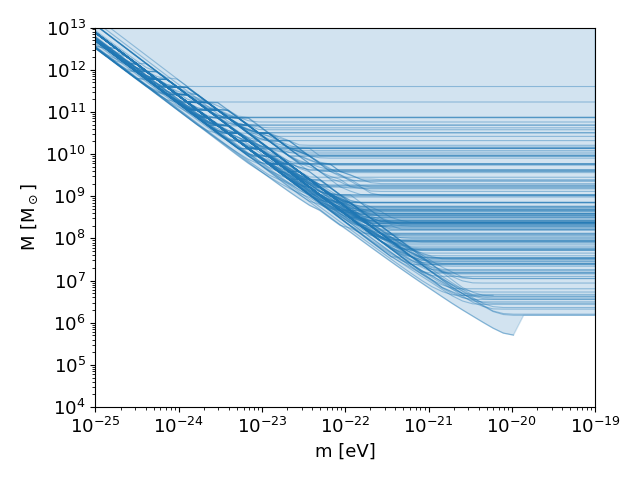

In [162]:
plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M [M$_\odot$]')
#plt.ylim(0.05, 10)
#plt.xlim(2e-24, 1e-19)
plt.ylim(1e4, 1e13)
plt.xlim(1e-25, 1e-19)

ratio_upper = 2
ratio_lower = 0.5

M_joint_arr = []
m_joint_arr = []
n_ind = 1

path_wild = '../../results_test11/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    with open(path, 'r') as f:
        results= pickle.load(f)      
        res_arr = results.storage
        scan.analyze(res_arr, res_arr[0].sigma_lvl)
        
        m_plt_arr = []
        M_plt_arr = []
        for result in res_arr:
            if not result.sane:
                continue            
            m = result.m
            M = result.M_contours[n_ind]
            m_plt_arr.append(m)
            M_plt_arr.append(M)
        
        # the bound
        m_plt_arr = np.asarray(m_plt_arr)        
        Msol_SH_arr = model.M_SH(m_plt_arr, result.gal)
        ratio_arr = M_plt_arr/ Msol_SH_arr
        
        plt.plot(m_plt_arr, M_plt_arr, lw='0.8', color='C0', alpha=0.4)
        
        m_joint_arr, M_joint_arr = scan.lower_array(m_joint_arr, M_joint_arr, m_plt_arr, M_plt_arr)

# the joint bound
plt.fill_between(m_plt_arr, M_joint_arr, 1e20, color='C0', alpha=0.2)
#bound_dct[str(n_ind)] = (m_plt_arr, M_joint_arr)

# # the SH prediction
# x = np.logspace(-25, -18)
# y = [1] * 50
# ylow = [ratio_lower] * 50
# yup = [ratio_upper] * 50
# plt.fill_between(x, ylow, yup, alpha=0.5, color='C1', zorder=3)
# plt.plot(x, y, 'k--')

# m_test = np.logspace(-24, -22.8)
# M_test = 8*(m_test/1e-24)**(-1/2)
# plt.plot(m_test, M_test, 'b--', zorder=5)

# m_test = np.logspace(-20.5, -19)
# M_test = 2.*(m_test/m_test[0])
# plt.plot(m_test, M_test, 'b--', zorder=5)

plt.rcParams.update({'font.size': 13})
plt.tight_layout()

#plt.savefig('./plots/sol_full_SPARC_2sigma.pdf')

In [164]:
# get the sigma levels

path_wild = '../../results_test10/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    with open(path, 'r') as f:
        results= pickle.load(f)      
        res_arr = results.storage

        m_plt_arr = []
        M_plt_arr = []
        for result in res_arr:         
            sigma_lvl_arr = result.sigma_lvl    
            break
    break
    
# get sigma index
print('scan %s have the following sigma levels: %s' %(path_wild, sigma_lvl_arr))

scan ../../results_test10/* have the following sigma levels: [1, 2, 3, 4, 5, 10]


In [416]:
# the sigma indices need to really exist corresponding to result.sigma_lvl
for n_ind in [1, 2,4,5]:
    
    M_joint_arr = []
    m_joint_arr = []

#     path_wild = '../../results_test10/*'
#     path_arr = glob.glob(path_wild)
    for path in path_arr:
        with open(path, 'r') as f:
            results= pickle.load(f)      
            res_arr = results.storage
            scan.analyze(res_arr, res_arr[0].sigma_lvl)                

            m_plt_arr = []
            M_plt_arr = []
            for result in res_arr:
                if not result.sane:
                    continue      
                
                m = result.m
                M = result.M_contours[n_ind]
                m_plt_arr.append(m)
                M_plt_arr.append(M)

            # the bound
            m_plt_arr = np.asarray(m_plt_arr)        
            Msol_SH_arr = model.M_SH(m_plt_arr, result.gal)
            ratio_arr = M_plt_arr/ Msol_SH_arr
            mask = ratio_arr < ratio_upper * 10
            m_joint_arr, M_joint_arr = scan.lower_array(m_joint_arr, M_joint_arr, m_plt_arr, ratio_arr)

    # the joint bound
    bound_dct[str(n_ind)] = (m_plt_arr, M_joint_arr)


<IPython.core.display.Javascript object>


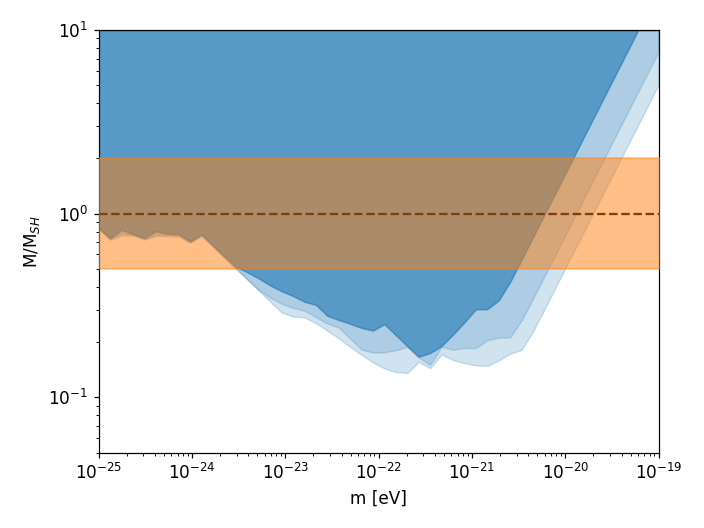

In [417]:
plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M/M$_{SH}$')
plt.ylim(0.05, 10)
plt.xlim(1e-25, 1e-19)

# 3sigma
(m, Mratio) = bound_dct['2']
plt.fill_between(m, Mratio, 10, alpha=0.2, color='C0')

# 5sigma
(m, Mratio) = bound_dct['4']
plt.fill_between(m, Mratio, 10, alpha=0.2, color='C0')

# 10sigma
(m, Mratio) = bound_dct['5']
plt.fill_between(m, Mratio, 10, alpha=0.6, color='C0')


# the SH prediction
x = np.logspace(-25, -18)
y = [1] * 50
ylow = [ratio_lower] * 50
yup = [ratio_upper] * 50
plt.fill_between(x, ylow, yup, alpha=0.5, color='C1', zorder=3)
plt.plot(x, y, 'k--')

plt.rcParams.update({'font.size': 13})
plt.tight_layout()

plt.savefig('./plots/sol_full_SPARC_combine.pdf')

<IPython.core.display.Javascript object>


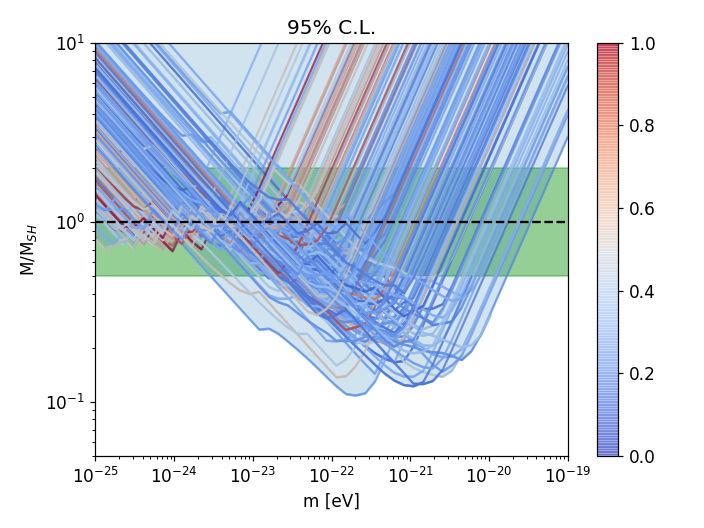

In [196]:
_, ax = plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M/M$_{SH}$')
plt.ylim(0.05, 10)
plt.xlim(1e-25, 1e-19)

ratio_upper = 2
ratio_lower = 0.5
f_cut = 1

M_joint_arr = []
m_joint_arr = []
n_ind = 1

path_wild = '../../results_test10/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    with open(path, 'r') as f:
        results= pickle.load(f)      
        res_arr = results.storage
        scan.analyze(res_arr, res_arr[0].sigma_lvl)        
        
        m_plt_arr = []
        M_plt_arr = []
        for result in res_arr:
            if not result.sane:
                continue            
            m = result.m
            M = result.M_contours[n_ind]
            m_plt_arr.append(m)
            M_plt_arr.append(M)
        
        # the bound
        m_plt_arr = np.asarray(m_plt_arr)        
        Msol_SH_arr = model.M_SH(m_plt_arr, result.gal)
        ratio_arr = M_plt_arr/ Msol_SH_arr
        mask = ratio_arr < ratio_upper * 10
        m_plt_finer_arr = np.logspace(np.log10(m_plt_arr[0]), np.log10(m_plt_arr[-1]), 1000)
        ratio_finer_arr = np.exp(np.interp(np.log(m_plt_finer_arr), 
                                           np.log(m_plt_arr), 
                                           np.log(ratio_arr)))
        M_plt_finer_arr = np.exp(np.interp(np.log(m_plt_finer_arr), 
                                           np.log(m_plt_arr), 
                                           np.log(M_plt_arr)))        
        fbar2DM =[]
        for i, mm in enumerate(m_plt_finer_arr):
            MMsol = M_plt_finer_arr[i]
            val = model.bar_ratio_at_peak(result.gal, MMsol)            
            val = min(val, 1)
            fbar2DM.append(val)
            if val > f_cut:
                ratio_finer_arr[i] = 100
        fbar2DM[0] = 0
        fbar2DM[1] = 1
        sc = plt.scatter(m_plt_finer_arr, ratio_finer_arr, s=0.4, c=(fbar2DM), cmap=cm.coolwarm, alpha=0.5)               
        m_joint_arr, M_joint_arr = scan.lower_array(m_joint_arr, M_joint_arr, m_plt_finer_arr, ratio_finer_arr)

        
plt.colorbar(sc)

# the joint bound
plt.fill_between(m_joint_arr, M_joint_arr, 10, color='C0', alpha=0.2)
bound_dct[str(n_ind)] = (m_plt_arr, M_joint_arr)

# the SH prediction
x = np.logspace(-25, -18)
y = [1] * 50
ylow = [ratio_lower] * 50
yup = [ratio_upper] * 50
plt.fill_between(x, ylow, yup, alpha=0.5, color='C2', zorder=0)
plt.plot(x, y, 'k--')
plt.title('95% C.L.')

plt.rcParams.update({'font.size': 11})
plt.tight_layout()

plt.savefig('./plots/sol_full_SPARC_2sigma_cmap.png')

# Check rotation curves of galaxies

In [203]:
# find the top runners
M_joint_arr = []
m_joint_arr = []
#name_joint_arr = []
data_dct = {}
n_ind = 1 # 2sigmas

path_wild = '../../results_test10/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    with open(path, 'r') as f:
        results= pickle.load(f)      
        res_arr = results.storage

        m_plt_arr = []
        M_plt_arr = []
        for result in res_arr:
            if not result.sane:
                continue            
            m = result.m
            M = result.M_contours[n_ind]
            m_plt_arr.append(m)
            M_plt_arr.append(M)
            try:
                data_dct[str(m)]
            except KeyError:
                data_dct[str(m)] = []
            data_dct[str(m)].append((M, result.gal.name))

In [251]:
# find top few in each m slice
rank_dct = {}
top_runner_arr = []
output_arr = [] # the log array

for key in data_dct.keys():
    rank_dct[key] = sorted(data_dct[key], key=lambda x:float(x[0]))
    top_n = 2
    # list of tuples to 2D array
    names_arr = np.array(rank_dct[key][:top_n])
    #print('m=%.1e has a bound of %.1e Msun from %s' %(float(key), float(names_arr[0,0]), names_arr[0,1]))
    output_str = 'm=%.1e has a bound of %.1e Msun from %s' %(float(key), float(names_arr[0,0]), names_arr[0,1])
    output_arr.append((float(key), output_str))
    # only save names
    names_arr = names_arr[:,1]
    top_runner_arr.append(names_arr)

top_runner_arr = np.array(top_runner_arr)
# get unique
top_runner_arr = np.unique(top_runner_arr.reshape(-1))

In [262]:
output_arr = np.array(sorted(output_arr, key=lambda x:float(x[0])))
for x in output_arr:
    print(x[1])

m=1.0e-25 has a bound of 2.2e+12 Msun from UGC09133
m=1.3e-25 has a bound of 1.5e+12 Msun from UGC00128
m=1.8e-25 has a bound of 9.5e+11 Msun from UGC00128
m=2.3e-25 has a bound of 6.3e+11 Msun from UGC00128
m=3.1e-25 has a bound of 4.1e+11 Msun from UGC00128
m=4.1e-25 has a bound of 2.7e+11 Msun from UGC00128
m=5.4e-25 has a bound of 1.8e+11 Msun from UGC07125
m=7.2e-25 has a bound of 1.2e+11 Msun from UGC07125
m=9.5e-25 has a bound of 7.9e+10 Msun from UGC07125
m=1.3e-24 has a bound of 5.4e+10 Msun from UGC07125
m=1.7e-24 has a bound of 4.0e+10 Msun from F563-V1
m=2.2e-24 has a bound of 2.7e+10 Msun from F563-V1
m=2.9e-24 has a bound of 1.8e+10 Msun from F563-V1
m=3.9e-24 has a bound of 1.2e+10 Msun from F563-V1
m=5.2e-24 has a bound of 8.5e+09 Msun from F563-V1
m=6.9e-24 has a bound of 6.0e+09 Msun from F563-V1
m=9.1e-24 has a bound of 3.9e+09 Msun from PGC51017
m=1.2e-23 has a bound of 2.6e+09 Msun from PGC51017
m=1.6e-23 has a bound of 1.7e+09 Msun from PGC51017
m=2.1e-23 has a bo

In [257]:
top_runner_arr

array(['CamB', 'D631-7', 'DDO161', 'F563-V1', 'IC2574', 'KK98-251',
       'NGC0289', 'PGC51017', 'UGC00128', 'UGC01281', 'UGC04305',
       'UGC04483', 'UGC07125', 'UGC09133'], dtype='|S32')

# check single galaxy

Check bounds from specific galaxy

In [19]:
# Redo the contour finding

In [146]:
result = results.storage[2]

# chi2_to_interp_arr = np.concatenate(
#     ([result.chi2_arr[np.logical_not(mask)][-1]], result.chi2_arr[mask]))

chi2_to_interp_arr = np.concatenate(
    ([1e-10], result.chi2_arr[mask]))

M_to_interp_arr = np.concatenate(
    ([result.M_arr[np.logical_not(mask)][-1]], result.M_arr[mask]))


<IPython.core.display.Javascript object>


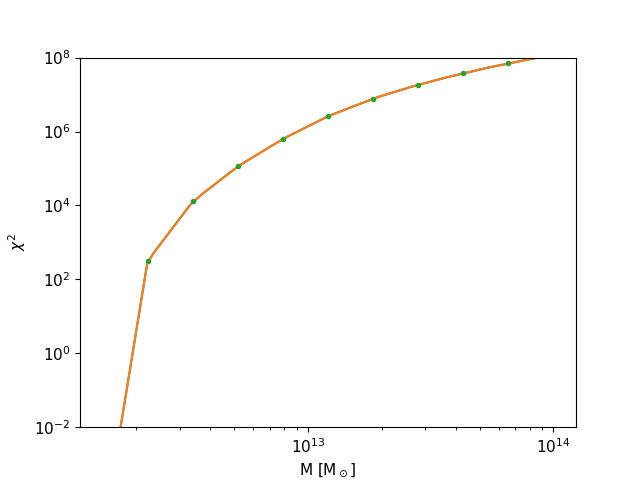

(0.01, 100000000.0)

In [179]:
y_arr = np.logspace(-5, 8)
#x_interp1d_arr = 10**interp1d(result.chi2_arr[mask], np.log10(result.M_arr[mask]))(y_arr)
# x_interp_arr = 10**np.interp(y_arr, result.chi2_arr[mask], np.log10(result.M_arr[mask]))
x_interp1d_arr = 10**interp1d(np.log10(chi2_to_interp_arr), np.log10(M_to_interp_arr), kind='linear')(np.log10(y_arr))
x_interp_arr = 10**np.interp(np.log10(y_arr), np.log10(chi2_to_interp_arr), np.log10(M_to_interp_arr))

plt.subplots()
plt.plot(x_interp1d_arr, y_arr)
plt.plot(x_interp_arr, y_arr)

plt.plot(M_to_interp_arr, chi2_to_interp_arr, '.')
plt.xscale('log')
plt.yscale('log')
#plt.ylim(-1, 10)
#plt.xlim(1e12, 2e12)
plt.ylabel('$\chi^2$')
plt.xlabel('M [M$_\odot$]')
plt.ylim(1e-2, 1e8)

<IPython.core.display.Javascript object>


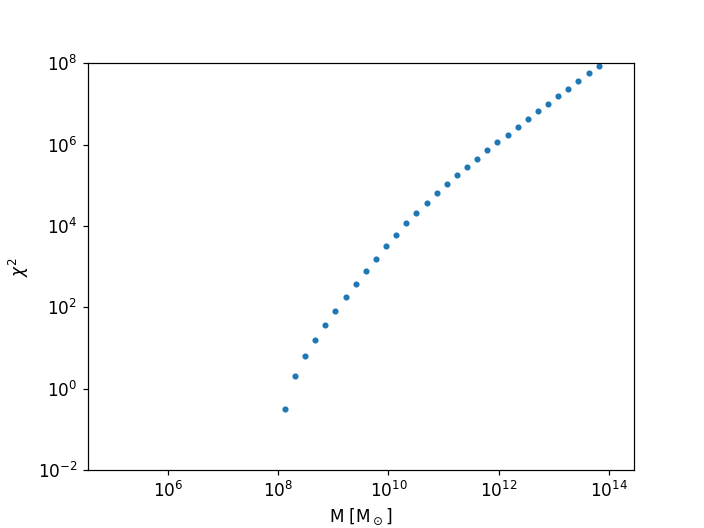

(0.01, 100000000.0)

In [414]:
plt.subplots()
plt.plot(result.M_arr, result.chi2_arr, '.')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$\chi^2$')
plt.xlabel('M [M$_\odot$]')
plt.ylim(1e-2, 1e8)

<IPython.core.display.Javascript object>


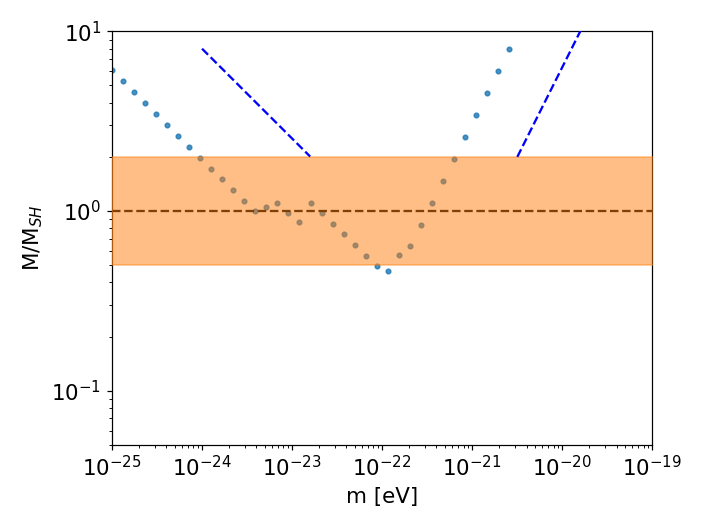

In [1287]:
#name_arr = ['UGC07125', 'UGC09133', 'UGC00128']
#name_arr = ['UGC00128']
name_arr = ['UGC04325']

plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M/M$_{SH}$')
plt.ylim(0.05, 10)
#plt.xlim(2e-24, 1e-19)
plt.xlim(1e-25, 1e-19)

ratio_upper = 2
ratio_lower = 0.5

M_joint_arr = []
m_joint_arr = []
n_ind = 1

path_wild = '../../results_test11/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    with open(path, 'r') as f:
        results= pickle.load(f)             
        res_arr = results.storage
        
        # customize analyze here
        scan.analyze(res_arr, res_arr[0].sigma_lvl)
        
        m_plt_arr = []
        M_plt_arr = []
        for result in res_arr:
            if not(result.gal.name in name_arr):
                continue
            if not result.sane:
                continue            
            m = result.m
            M = result.M_contours[n_ind]
            m_plt_arr.append(m)
            M_plt_arr.append(M)
            
        
        # the bound
        m_plt_arr = np.asarray(m_plt_arr)        
        Msol_SH_arr = model.M_SH(m_plt_arr, result.gal)
        ratio_arr = M_plt_arr/ Msol_SH_arr
        mask = ratio_arr < ratio_upper * 10
        plt.plot(m_plt_arr[mask], ratio_arr[mask], '.', lw='0.8', color='C0', alpha=0.8)
        
        m_joint_arr, M_joint_arr = scan.lower_array(m_joint_arr, M_joint_arr, m_plt_arr, ratio_arr)

# # the joint bound
# plt.fill_between(m_plt_arr, M_joint_arr, 10, color='C0', alpha=0.2)

# the SH prediction
x = np.logspace(-25, -18)
y = [1] * 50
ylow = [ratio_lower] * 50
yup = [ratio_upper] * 50
plt.fill_between(x, ylow, yup, alpha=0.5, color='C1', zorder=3)
plt.plot(x, y, 'k--')

m_test = np.logspace(-24, -22.8)
M_test = 8*(m_test/1e-24)**(-1/2)
plt.plot(m_test, M_test, 'b--', zorder=5)

m_test = np.logspace(-20.5, -19)
M_test = 2.*(m_test/m_test[0])
plt.plot(m_test, M_test, 'b--', zorder=5)

plt.rcParams.update({'font.size': 13})
plt.tight_layout()



<IPython.core.display.Javascript object>


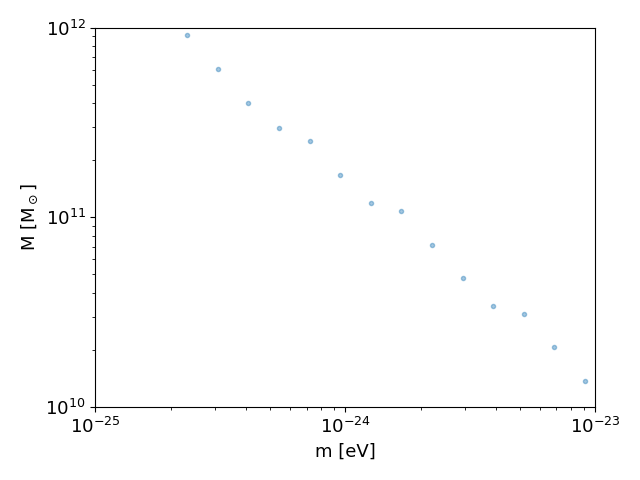

In [182]:
plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M [M$_\odot$]')
#plt.ylim(0.05, 10)
#plt.xlim(2e-24, 1e-19)
plt.ylim(1e10, 1e12)
plt.xlim(1e-25, 1e-23)

ratio_upper = 2
ratio_lower = 0.5

M_joint_arr = []
m_joint_arr = []
n_ind = 1

path_wild = '../../results_test11/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    with open(path, 'r') as f:
        results= pickle.load(f)      
        res_arr = results.storage
        scan.analyze(res_arr, res_arr[0].sigma_lvl)        
        
        m_plt_arr = []
        M_plt_arr = []
        for result in res_arr:
            if not(result.gal.name in name_arr):
                continue
            if not result.sane:
                continue            
            m = result.m
            M = result.M_contours[n_ind]
            m_plt_arr.append(m)
            M_plt_arr.append(M)
        
        # the bound
        m_plt_arr = np.asarray(m_plt_arr)        
        Msol_SH_arr = model.M_SH(m_plt_arr, result.gal)
        ratio_arr = M_plt_arr/ Msol_SH_arr
        
        plt.plot(m_plt_arr, M_plt_arr, '.', lw='0.8', color='C0', alpha=0.4)
        
        m_joint_arr, M_joint_arr = scan.lower_array(m_joint_arr, M_joint_arr, m_plt_arr, M_plt_arr)

# the joint bound
#plt.fill_between(m_plt_arr, M_joint_arr, 1e20, color='C0', alpha=0.2)

plt.rcParams.update({'font.size': 13})
plt.tight_layout()

#plt.savefig('./plots/sol_full_SPARC_2sigma.pdf')

In [263]:
# plot out the rot curves

<IPython.core.display.Javascript object>


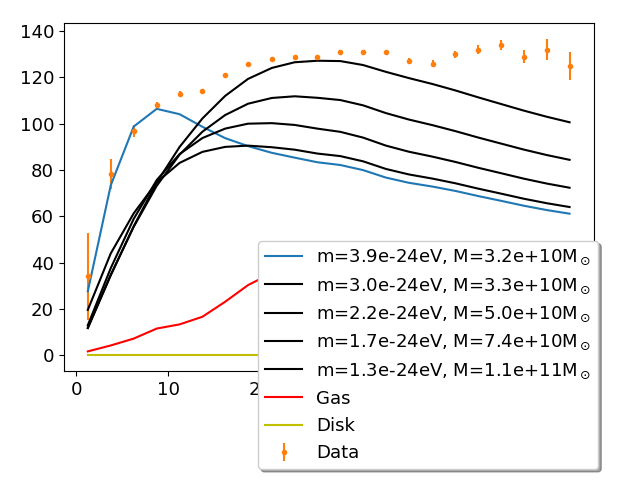

0.5986492339679107
0
0
0
0


In [192]:
gal = spc.findGalaxyByName('UGC00128', data)
plt.subplots()

DM_profile = 'Burkert'


m = 3.948e-24
M = 3.17*10**10
ups_bulg = 0.
ups_disk = 0.
c = 0.
Rs = 0.1

chi2_val, Vtot = chi2.chi2_single_gal(m, M, c, Rs, ups_disk, ups_bulg, gal, 
                                      flg_Vtot=True, DM_profile=DM_profile, flg_overshoot=True)
print(chi2_val)
plt.plot(gal.R, Vtot, '-', label='m=%.1eeV, M=%.1eM$_\odot$' %(m,M))


m = 2.95e-24
M = 3.28*10**10
ups_bulg = 0.263
ups_disk = 0.263
c = 0.
Rs = 0.1

chi2_val, Vtot = chi2.chi2_single_gal(m, M, c, Rs, ups_disk, ups_bulg, gal, 
                                      flg_Vtot=True, DM_profile=DM_profile, flg_overshoot=True)
print(chi2_val)
plt.plot(gal.R, Vtot, 'k-', label='m=%.1eeV, M=%.1eM$_\odot$' %(m,M))



m = 2.24e-24
M = 5.04*10**10
ups_bulg = 0.
ups_disk = 0.
c = 0.
Rs = 0.1

chi2_val, Vtot = chi2.chi2_single_gal(m, M, c, Rs, ups_disk, ups_bulg, gal, 
                                      flg_Vtot=True, DM_profile=DM_profile, flg_overshoot=True)
print(chi2_val)
plt.plot(gal.R, Vtot, 'k-',  label='m=%.1eeV, M=%.1eM$_\odot$' %(m,M))



m = 1.68e-24
M = 7.41*10**10
ups_bulg = 0.
ups_disk = 0.
c = 0.
Rs = 0.1

chi2_val, Vtot = chi2.chi2_single_gal(m, M, c, Rs, ups_disk, ups_bulg, gal, 
                                      flg_Vtot=True, DM_profile=DM_profile, flg_overshoot=True)
print(chi2_val)
plt.plot(gal.R, Vtot, 'k-',  label='m=%.1eeV, M=%.1eM$_\odot$' %(m,M))



m = 1.27e-24
M = 1.12*10**11
ups_bulg = 0.
ups_disk = 0.
c = 0.
Rs = 0.1

chi2_val, Vtot = chi2.chi2_single_gal(m, M, c, Rs, ups_disk, ups_bulg, gal, 
                                      flg_Vtot=True, DM_profile=DM_profile, flg_overshoot=True)
print(chi2_val)
plt.plot(gal.R, Vtot, 'k-',  label='m=%.1eeV, M=%.1eM$_\odot$' %(m,M))



# m = 1e-24
# M = 1.35*10**11
# ups_bulg = 0.8
# ups_disk = 0.8
# c = 0.
# Rs = 0.1

# chi2_val, Vtot = chi2.chi2_single_gal(m, M, c, Rs, ups_disk, ups_bulg, gal, 
#                                       flg_Vtot=True, DM_profile=DM_profile, flg_overshoot=True)
# print(chi2_val)
# plt.plot(gal.R, Vtot, 'k-', label='Vtot')




# m = 5.4e-25
# M = 2.7*10**11
# ups_bulg = 0.8
# ups_disk = 0.8
# c = 0.
# Rs = 0.1

# chi2_val, Vtot = chi2.chi2_single_gal(m, M, c, Rs, ups_disk, ups_bulg, gal, 
#                                       flg_Vtot=True, DM_profile=DM_profile, flg_overshoot=True)
# print(chi2_val)
# plt.plot(gal.R, Vtot, 'k-', label='Vtot')





# m = 4.12e-25
# M = 3.6*10**11
# ups_bulg = 0.8
# ups_disk = 0.8
# c = 0.
# Rs = 0.1

# chi2_val, Vtot = chi2.chi2_single_gal(m, M, c, Rs, ups_disk, ups_bulg, gal, 
#                                       flg_Vtot=True, DM_profile=DM_profile, flg_overshoot=True)
# print(chi2_val)
# plt.plot(gal.R, Vtot, 'k-', label='Vtot')




# m = 3.06e-25
# M = 4.27*10**11
# ups_bulg = 0.8
# ups_disk = 0.8
# c = 0.
# Rs = 0.1

# chi2_val, Vtot = chi2.chi2_single_gal(m, M, c, Rs, ups_disk, ups_bulg, gal, 
#                                       flg_Vtot=True, DM_profile=DM_profile, flg_overshoot=True)
# print(chi2_val)
# plt.plot(gal.R, Vtot, 'k-', label='Vtot')



plt.errorbar(gal.R, gal.Vobs, gal.dVobs, fmt='.', label='Data')
plt.plot(gal.R, gal.Vgas,'r-', label='Gas')
plt.plot(gal.R, np.sqrt(ups_disk)*gal.Vdisk,'y-', label='Disk')

#plt.legend(loc='best')
plt.legend(bbox_to_anchor=(0.35, 0.4), ncol=1, fancybox=True, shadow=True)
plt.tight_layout()

# Translate to DM fraction

<IPython.core.display.Javascript object>


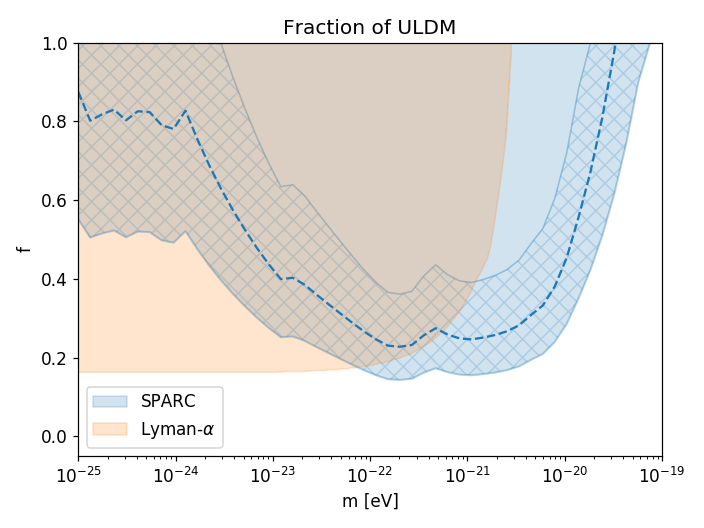

In [197]:
# plt.subplots()
# plt.xscale('log')
# #plt.yscale('log')
# plt.xlabel('m [eV]')
# plt.ylabel('f')
# plt.title('Fraction of ULDM')
# plt.ylim(-0.05, 1)
# #plt.xlim(2e-24, 1e-19)
# plt.xlim(1e-25, 1e-19)

# ratio_upper = 2
# ratio_lower = 0.5

# M_joint_arr = []
# m_joint_arr = []
# n_ind = 1

# path_wild = '../../results_test10/*'
# path_arr = glob.glob(path_wild)
# for path in path_arr:
#     with open(path, 'r') as f:
#         results= pickle.load(f)      
#         res_arr = results.storage
#         scan.analyze(res_arr, res_arr[0].sigma_lvl)        
        
#         m_plt_arr = []
#         M_plt_arr = []
#         for result in res_arr:
#             if not result.sane:
#                 continue            
#             m = result.m
#             M = result.M_contours[n_ind]
#             m_plt_arr.append(m)
#             M_plt_arr.append(M)
        
#         # the bound
#         m_plt_arr = np.asarray(m_plt_arr)        
#         Msol_SH_arr = model.M_SH(m_plt_arr, result.gal)
#         ratio_arr = M_plt_arr/ Msol_SH_arr
        
#         m_joint_arr, M_joint_arr = scan.lower_array(m_joint_arr, M_joint_arr, m_plt_arr, ratio_arr)
        
# # the joint bound

# x = m_plt_arr
# y = M_joint_arr**(2./3)
# #mask = y < 1
# #plt.plot(x[mask], y[mask], color='C0', ls='--')
# plt.plot(x, y, color='C0', ls='--')

# yupper = (2. *M_joint_arr)**(2./3)
# ylower = (0.5*M_joint_arr)**(2./3)
# yupper[yupper>1] = 1.
# ylower[ylower>1] = 1.

# plt.fill_between(m_plt_arr, ylower, yupper, color='C0', alpha=0.2, hatch="xx")
# plt.fill_between(m_plt_arr, yupper, 100, color='C0', alpha=0.2, label='SPARC')
# plt.plot(m_plt_arr, ylower, color='C0', alpha=0.2)

# # overlay with Kobayashi
# path = '../data/Kobayashi2017.csv'
# data_lym_arr = np.loadtxt(path, delimiter=',')
# x = data_lym_arr[:,0]
# y = data_lym_arr[:,1]
# x = np.insert(x, 0, 1e-25)
# y = np.insert(y, 0, y[0])
# plt.fill_between(x, y, 100, color='C1', label=r'Lyman-$\alpha$', alpha=0.2)
# plt.legend(loc=3)
# plt.tight_layout()

# plt.savefig('./plots/f_2sigma.pdf')

<IPython.core.display.Javascript object>


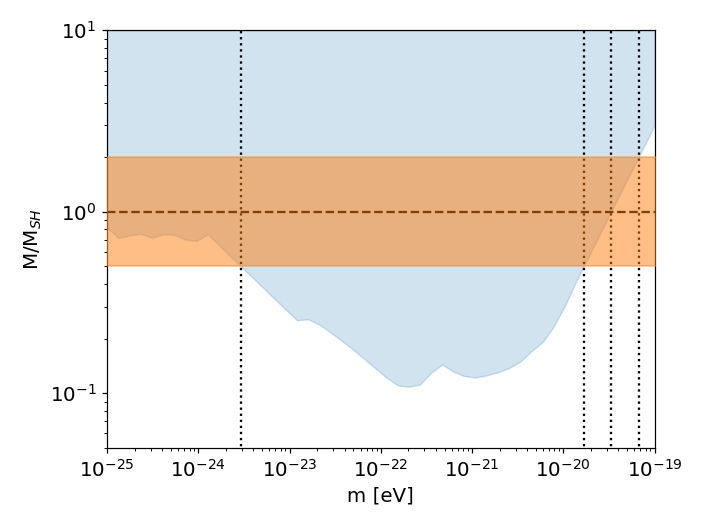

In [460]:
# output the range where SH is broken

plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M/M$_{SH}$')
plt.ylim(0.05, 10)
plt.xlim(1e-25, 1e-19)

# 2sigma
(m, Mratio) = bound_dct['1']
plt.fill_between(m, Mratio, 10, alpha=0.2, color='C0')


# the SH prediction
x = np.logspace(-25, -18)
y = [1] * 50
ylow = [ratio_lower] * 50
yup = [ratio_upper] * 50
plt.fill_between(x, ylow, yup, alpha=0.5, color='C1', zorder=3)
plt.plot(x, y, 'k--')


mask = np.where(m > 1e-20, True, False)
m0 = 10**np.interp(0., np.log10(Mratio[mask]), np.log10(m[mask]))
plt.vlines(m0, 0.001, 20, color='k', linestyle=':')
m_up_1 = m0

mask = np.where(m > 1e-20, True, False)
m0 = 10**np.interp(np.log10(2.), np.log10(Mratio[mask]), np.log10(m[mask]))
plt.vlines(m0, 0.001, 20, color='k', linestyle=':')
m_up_2 = m0

mask = np.where(m > 1e-20, True, False)
m0 = 10**np.interp(np.log10(0.5), np.log10(Mratio[mask]), np.log10(m[mask]))
plt.vlines(m0, 0.001, 20, color='k', linestyle=':')
m_up_05 = m0

mask1 = np.where(m < 1e-23, True, False)
mask2 = np.where(m > 2e-24, True, False)
mask = mask1*mask2
Mratio_arr = np.logspace(-1, 1)
y_arr = np.array([y for (_,y) in sorted(zip(np.log10(Mratio[mask]), np.log10(m[mask])))])
x_arr = sorted(np.log10(Mratio[mask]))
#minterp = np.array([10**np.interp(np.log10(Mi), x_arr, y_arr) for Mi in Mratio_arr])
m0 = 10**np.interp(np.log10(0.5), x_arr, y_arr)
plt.vlines(m0, 0.001, 20, color='k', linestyle=':')
m_low_05 = m0

m_low_1 = 1e-25
m_low_2 = 1e-25

plt.rcParams.update({'font.size': 13})
plt.tight_layout()

#plt.savefig('./plots/sol_full_SPARC_combine.pdf')

<IPython.core.display.Javascript object>


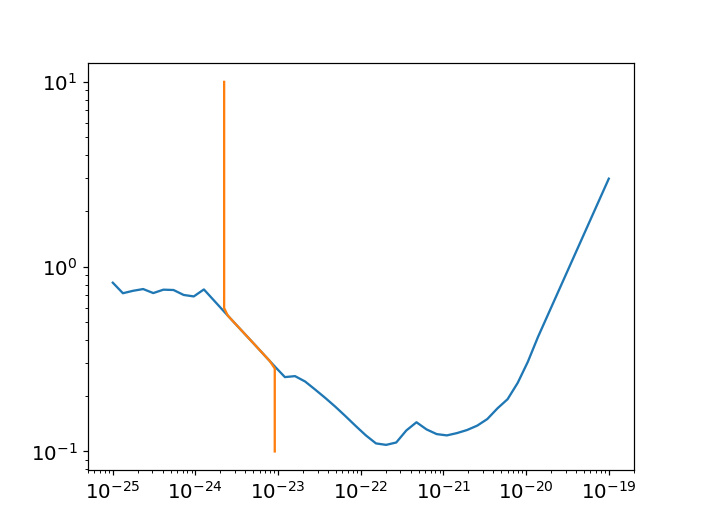

In [461]:
## Remember to always plot out the interpolation!!
# plt.subplots()
# plt.plot(m, Mratio)
# #mask = np.where(m > 3e-21, True, False)
# mask1 = np.where(m < 1e-23, True, False)
# mask2 = np.where(m > 2e-24, True, False)
# mask = mask1*mask2

# Mratio_arr = np.logspace(-1, 1)
# y_arr = np.array([y for (_,y) in sorted(zip(np.log10(Mratio[mask]), np.log10(m[mask])))])
# x_arr = sorted(np.log10(Mratio[mask]))
# minterp = np.array([10**np.interp(np.log10(Mi), x_arr, y_arr) for Mi in Mratio_arr])
# plt.plot(minterp, Mratio_arr)
# plt.yscale('log')
# plt.xscale('log')

In [1009]:
## check c griding
# plt.subplots()
# c_arr = np.logspace(0, 1.5)
# def del_c(c):
#     return 200./3 * c**3 / (np.log(1+c) - c/(1+c))
# plt.loglog(c_arr, del_c(c_arr), '.')


In [1008]:
## check boundary effect of the fit
for gal in data:
    try:
        print(gal.c)
    except:
        pass

23.542864143224165
20.0


In [1239]:
delattr(gal, 'c')
delattr(gal, 'rs')

In [925]:
#gal = spc.findGalaxyByName('UGCA444', data) 
gal = spc.findGalaxyByName('NGC2955', data) 
print(gal.name)
try:
    print(gal.c)
    print(gal.rs)
except:
    print("haven't fit it yet")

NGC2955
20.991037201085547
7.448979591836735


<IPython.core.display.Javascript object>


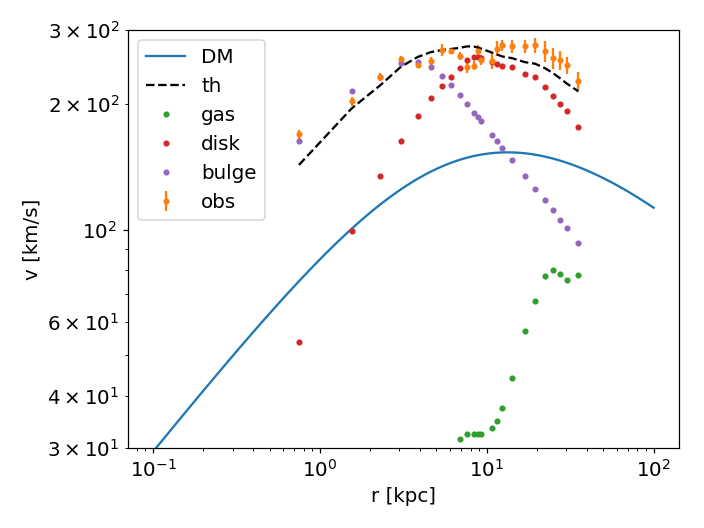

In [1006]:
plt.subplots()
r_arr = np.logspace(-1, 2, 100)

# density_fn, _, _ = model.reconstruct_density(gal)
# x = r_arr
# y = density_fn(x)
# plt.plot(x, y, '-')
# x, y = model.reconstruct_density_num(gal, flg_give_R=True)
# plt.plot(x, y, '.')

# mass_fn, _, _ = model.reconstruct_mass(gal)
# x = r_arr
# y = mass_fn(x)
# plt.plot(x, y, '-')

# x = gal.R
# y = model.reconstruct_mass_num(gal)
# plt.plot(x, y, '.')

mass_fn, _, _ = model.reconstruct_mass(gal)
x = r_arr
y = mass_fn(x)
v = np.sqrt(y/x / model._Mpl2_km2_over_s2_kpc_over_Msun_)
plt.plot(x, v, '-', label='DM')

# x = gal.R
# y = model.reconstruct_mass_num(gal)
# plt.plot(x, y/x / model._Mpl2_km2_over_s2_kpc_over_Msun_, '.')

vth2 = model.v2_rot(gal, gal.c, gal.rs, 0.5, 0.5, "NFW")
plt.plot(gal.R, np.sqrt(vth2), 'k--', label='th')

#plt.plot(gal.R, gal.Vobs**2, '.', label='obs')
plt.errorbar(gal.R, gal.Vobs, gal.dVobs, fmt='.', label='obs')
plt.plot(gal.R, gal.Vgas, '.', label='gas')
plt.plot(gal.R, gal.Vdisk, '.', label='disk')
plt.plot(gal.R, gal.Vbul, '.', label='bulge')

plt.legend(loc='best')
plt.ylim(30, 300)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r [kpc]')
#plt.ylabel(r'M [M$_\odot$]')
plt.ylabel(r'v [km/s]')
plt.tight_layout()

In [954]:
(rs_mesh, c_mesh, chi2_flat) = model.fit_rot_curve(gal, gridsize=200)

Process PoolWorker-1004:
Process PoolWorker-1002:
Process PoolWorker-997:
Process PoolWorker-1000:
Process PoolWorker-998:
Process PoolWorker-995:
Process PoolWorker-1007:
Process PoolWorker-989:
Process PoolWorker-991:
Process PoolWorker-992:
Process PoolWorker-993:
Process PoolWorker-990:
Process PoolWorker-994:
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-1005:
Process PoolWorker-1008:
Process PoolWorker-1003:
Process PoolWorker-1006:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-999:
Process PoolWorker-1001:
Process PoolWorker-996:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/a/home/cc/students/physics/chensun/app/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/a/home/cc/students/physics/chensun/app/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most 

  File "/a/home/cc/students/physics/chensun/app/anaconda2/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/a/home/cc/students/physics/chensun/app/anaconda2/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/a/home/cc/students/physics/chensun/app/anaconda2/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/a/home/cc/students/physics/chensun/app/anaconda2/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/a/home/cc/students/physics/chensun/app/anaconda2/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/a/home/cc/students/physics/chensun/app/anaconda2/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/a/home/cc/students/physics/chensun/app/anaconda2/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/a/home/cc/students/physics/chensun/app/anaconda2/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/a/home/cc/students/physics/chensun/app/anaconda

<IPython.core.display.Javascript object>


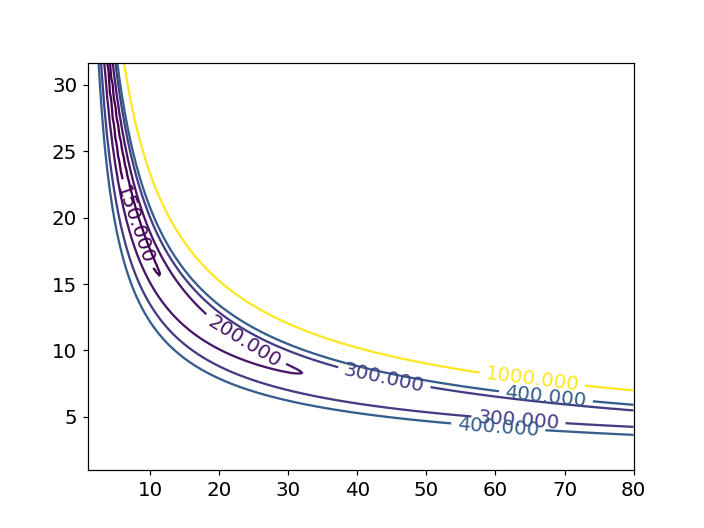

<a list of 7 text.Text objects>

In [955]:
plt.subplots()
cs = plt.contour(rs_mesh, c_mesh, chi2_flat.reshape(c_mesh.shape), levels=[100, 150, 200, 300, 400, 1000])
plt.clabel(cs)

<IPython.core.display.Javascript object>


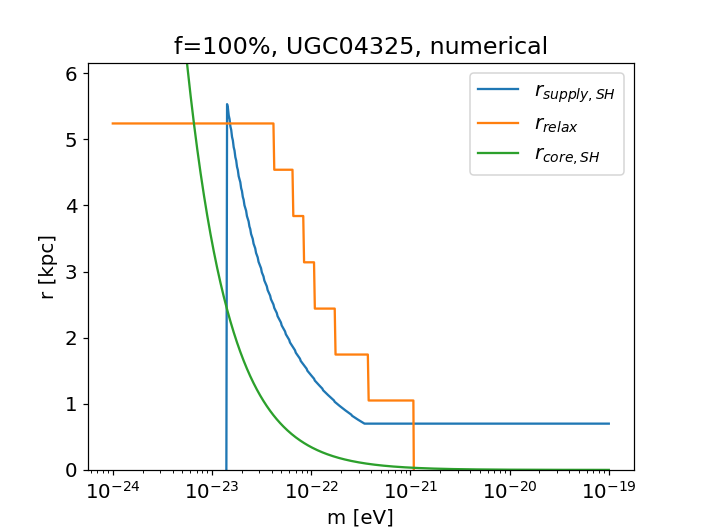

Text(0.5,0,'m [eV]')

In [1186]:
#gal = spc.findGalaxyByName('UGC00128', data) 
gal = spc.findGalaxyByName('UGC04325', data) 
f = 1
m_arr = np.logspace(-24, -19, 600)
r_supply_arr = np.array([model.supply_radius(f, m, gal, method='fit') for m in m_arr])
r_relax_arr = np.array([model.relax_radius(f, m, gal, method='num') for m in  m_arr])
r_core_arr = np.array([1.9 * model.rc(m, model.M_SH(m, gal)) for m in m_arr])

plt.subplots()
plt.plot(m_arr, r_supply_arr, label=r'$r_{supply, SH}$')
plt.plot(m_arr, r_relax_arr, label=r'$r_{relax}$')
plt.plot(m_arr, r_core_arr, label=r'$r_{core, SH}$')

plt.xscale('log')
#ymin, ymax = plt.ylim()
plt.ylim(0, gal.R[-1]*1.1)
plt.title('f=%.0f%%, %s, numerical' %(100*f, gal.name))
plt.legend(loc='best')
plt.ylabel('r [kpc]')
plt.xlabel('m [eV]')

<IPython.core.display.Javascript object>


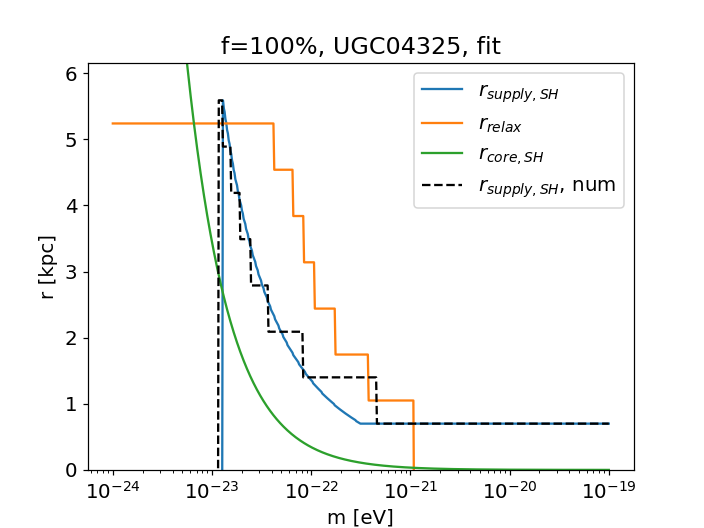

You chose to use total mass to supply the growth of BEC core. This is              technically incorrect. Need to subtract the baryonic component,              then multiply by the fraction of the correct species. 
You chose to use total mass to supply the growth of BEC core. This is              technically incorrect. Need to subtract the baryonic component,              then multiply by the fraction of the correct species. 
You chose to use total mass to supply the growth of BEC core. This is              technically incorrect. Need to subtract the baryonic component,              then multiply by the fraction of the correct species. 
You chose to use total mass to supply the growth of BEC core. This is              technically incorrect. Need to subtract the baryonic component,              then multiply by the fraction of the correct species. 
You chose to use total mass to supply the growth of BEC core. This is              technically incorrect. Need to subtract the baryonic comp

Text(0.5,0,'m [eV]')

In [1267]:
##### gal = spc.findGalaxyByName('UGC00128', data) 
gal = spc.findGalaxyByName('UGC04325', data) 
# gal = spc.findGalaxyByName('NGC2955', data) 
f = 1
m_arr = np.logspace(-24, -19, 600)
r_supply_arr = np.array([model.supply_radius(f, m, gal) for m in m_arr])
r_relax_arr = np.array([model.relax_radius(f, m, gal) for m in  m_arr])
r_core_arr = np.array([1.9 * model.rc(m, model.M_SH(m, gal)) for m in m_arr])

plt.subplots()
plt.plot(m_arr, r_supply_arr, label=r'$r_{supply, SH}$')
plt.plot(m_arr, r_relax_arr, label=r'$r_{relax}$')
plt.plot(m_arr, r_core_arr, label=r'$r_{core, SH}$')

r_supply_arr = np.array([model.supply_radius(f, m, gal, method='num') for m in m_arr])
#r_relax_arr = np.array([model.relax_radius(f, m, gal, method='num') for m in  m_arr])
plt.plot(m_arr, r_supply_arr, 'k--', label=r'$r_{supply, SH}$, num')
#plt.plot(m_arr, r_relax_arr, 'k:', label=r'$r_{relax}$, num')

plt.xscale('log')
#ymin, ymax = plt.ylim()
plt.ylim(0, gal.R[-1]*1.1)
plt.title('f=%.0f%%, %s, fit' %(100*f, gal.name))
plt.legend(loc='best')
plt.ylabel('r [kpc]')
plt.xlabel('m [eV]')

In [317]:
## test the two radii

# m = 1e-24
# f = 1
# print(model.supply_radius(f, m, gal))
# print(model.relax_radius(f, m, gal))

In [318]:
## test the density drop of the soliton profile

# m = 1e-26
# M = model.M_SH(m, gal)*3.
# model.rho_sol(model.rc(m, M)*1.9, m, M) / model.rho_sol(0., m, M)

<IPython.core.display.Javascript object>


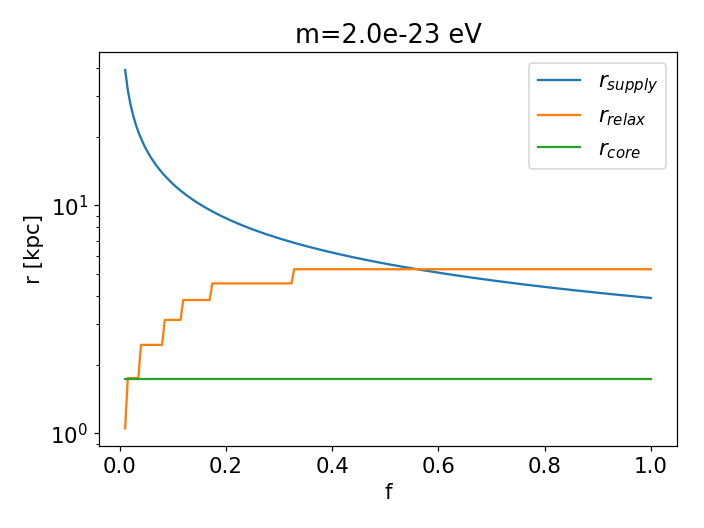

In [1270]:
f_arr = np.linspace(0.01, 1, 200)
m = 2e-23
r_supply_arr = np.array([model.supply_radius(f, m, gal) for f in f_arr])
r_relax_arr = np.array([model.relax_radius(f, m, gal) for f in  f_arr])
r_core_arr = np.array([1.9 * model.rc(m, model.M_SH(m, gal)) for f in  f_arr])

plt.subplots()
plt.plot(f_arr, r_supply_arr, label=r'$r_{supply}$')
plt.plot(f_arr, r_relax_arr, label=r'$r_{relax}$')
plt.plot(f_arr, r_core_arr, label=r'$r_{core}$')

#plt.xscale('log')
plt.yscale('log')
plt.ylabel('r [kpc]')
plt.xlabel('f')
plt.title('m=%.1e eV' %m)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('./plots/r_comparison_%s.pdf' %(gal.name))

<IPython.core.display.Javascript object>


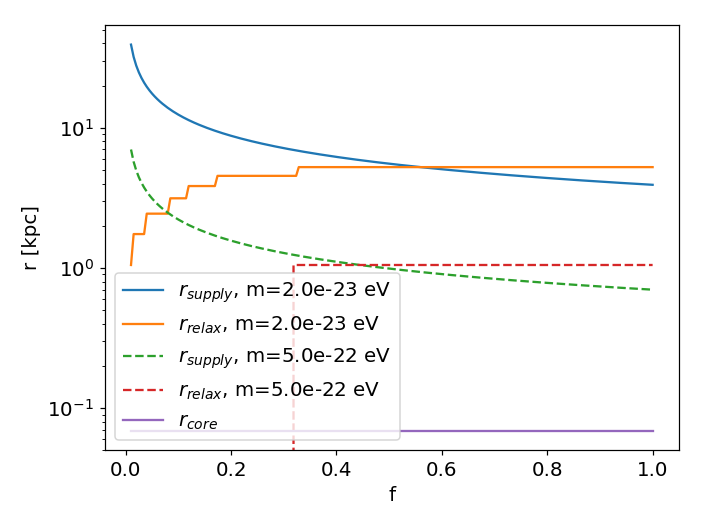

In [1245]:
plt.subplots()

f_arr = np.linspace(0.01, 1, 200)

m = 2e-23

r_supply_arr = np.array([model.supply_radius(f, m, gal) for f in f_arr])
plt.plot(f_arr, r_supply_arr, label=r'$r_{supply}$, m=%.1e eV' %m)

r_relax_arr = np.array([model.relax_radius(f, m, gal) for f in  f_arr])
plt.plot(f_arr, r_relax_arr, label=r'$r_{relax}$, m=%.1e eV' %m)

m = 5e-22

r_supply_arr = np.array([model.supply_radius(f, m, gal) for f in f_arr])
plt.plot(f_arr, r_supply_arr, '--', label=r'$r_{supply}$, m=%.1e eV' %m)

r_relax_arr = np.array([model.relax_radius(f, m, gal) for f in  f_arr])
plt.plot(f_arr, r_relax_arr, '--', label=r'$r_{relax}$, m=%.1e eV' %m)



r_core_arr = np.array([1.9 * model.rc(m, model.M_SH(m, gal)) for f in  f_arr])
plt.plot(f_arr, r_core_arr, label=r'$r_{core}$')

#plt.xscale('log')
plt.yscale('log')
plt.ylabel('r [kpc]')
plt.xlabel('f')
#plt.title('m=%.1e eV' %m)
plt.legend(loc='best')
plt.tight_layout()

<IPython.core.display.Javascript object>


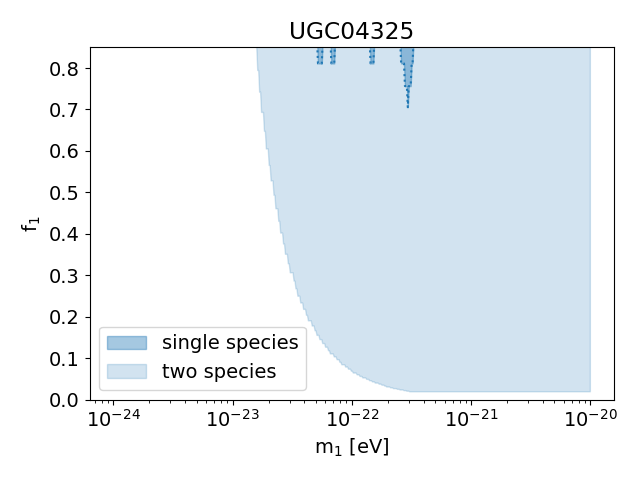

m$_2$=1.0e-23 eV, f$_2$=15%


In [10]:
#gal = spc.findGalaxyByName('NGC2955', data) 
gal = spc.findGalaxyByName('UGC04325', data) 
#gal = spc.findGalaxyByName('UGC00128', data) 
m_arr = np.logspace(-24, -20, 500)
f_arr = []
for m in m_arr:
    f_arr.append(model.f_critical(m, gal, factor=1.))
    
# rescale small m part

plt.subplots()
plt.fill_between(m_arr, f_arr, 1., color='C0', alpha=0.4, interpolate='nearest', label='single species')
plt.plot(m_arr, f_arr, ':', color='C0', alpha=1.)


## if we ignore baryon component, and assume the galaxy is dominated by DM
# m_arr = np.logspace(-24, -20, 500)
# f_arr = []
# for m in m_arr:
#     f_arr.append(model.f_critical(m, gal, 'num'))
# #plt.fill_between(m_arr, f_arr, 1., color='C0', alpha=0.4, interpolate='nearest')
# plt.plot(m_arr, f_arr, ':', color='C1', alpha=1.)


# two species:
m_arr = np.logspace(-24, -20, 500)
f_arr = []
m2 = 1e-23
f2 = 0.15
for m1 in m_arr:
    f_arr.append(model.f_critical_two_species(m1, m2, f2, gal))
plt.fill_between(m_arr, f_arr, 1., color='C0', alpha=0.2, interpolate='nearest', label='two species')  
print('m$_2$=%.1e eV, f$_2$=%.0f%%' %(m2, f2*100))


plt.xscale('log')
ymin, ymax = plt.ylim()
plt.ylim(0, 1.-f2)
plt.ylabel('f$_1$')
plt.xlabel('m$_1$ [eV]')
plt.title('%s' %(gal.name))
plt.legend(loc=3)
plt.tight_layout()
#plt.tight_layout()
#plt.savefig('./plots/f1_m1_fixed_f2_m2_%s.pdf' %(gal.name))

In [24]:
# combine galaxies
# the sigma indices need to really exist corresponding to result.sigma_lvl

f_dct_one_species = {}

def func(gal):
    m_arr = np.logspace(-25, -19, 300)
    f_arr = []
    for m in m_arr:
        f_arr.append(model.f_critical(m, gal,  factor=1.5)) # factor=2.))

    f_arr = np.array(f_arr)
    return (gal, m_arr, f_arr)
        
with closing(Pool()) as pool:
    res = pool.map(func, data)
    for gal, m_arr, f_arr in res:
        f_dct_one_species[gal.name] = (m_arr, f_arr)
    pool.terminate()


In [1250]:
# to make SH relation fail, f has to drop to at least this little

<IPython.core.display.Javascript object>


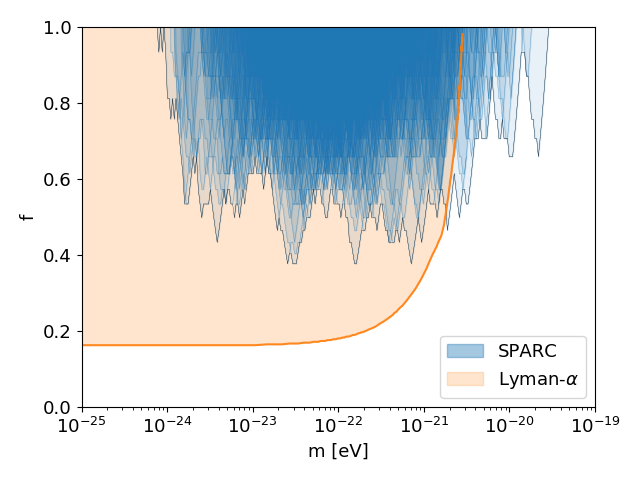

In [25]:
f_joint_arr = []
m_joint_arr = []

plt.subplots() 
flg_label = True
for (galname, (m_arr, f_arr)) in f_dct_one_species.iteritems():
#     mask1 = np.where(m_arr>m_low_1, True, False)
#     mask2 = np.where(m_arr<m_up_1, True, False)
#     mask = mask1 * mask2
    try:
        log10mlow_sol, log10mup_sol = bound_range_dct[galname]
    except:
        continue
    mask1 = np.where(m_arr>10**log10mlow_sol.root, True, False)
    mask2 = np.where(m_arr<10**log10mup_sol.root, True, False)
    mask = mask1 * mask2    
    if sum(mask) > 0:
        if flg_label is True:
            plt.fill_between(m_arr[mask], f_arr[mask], 1., color='C0', alpha=0.4, interpolate='nearest', label='SPARC')        
            flg_label = False
        else:
            plt.fill_between(m_arr[mask], f_arr[mask], 1., color='C0', alpha=0.1, interpolate='nearest')        
            plt.plot(m_arr[mask], f_arr[mask], color='C0', alpha=0.6, lw='0.3')        
        m_joint_arr, f_joint_arr = scan.lower_array(m_joint_arr, f_joint_arr, m_arr[mask], f_arr[mask])

# # the SPARC common boundary 
# plt.vlines(m_low_05, 0.001, 20, color='k', linestyle=':')
# plt.vlines(m_low_1, 0.001, 20, color='k', linestyle=':')
# plt.vlines(m_low_2, 0.001, 20, color='k', linestyle=':')
# plt.vlines(m_up_05, 0.001, 20, color='k', linestyle=':')
# plt.vlines(m_up_1, 0.001, 20, color='k', linestyle=':')
# plt.vlines(m_up_2, 0.001, 20, color='k', linestyle=':')

# check the edge
plt.plot(m_joint_arr, f_joint_arr, 'k', lw=0.2)

# overlay with Kobayashi
path = '../data/Kobayashi2017.csv'
data_lym_arr = np.loadtxt(path, delimiter=',')
x = data_lym_arr[:,0]
y = data_lym_arr[:,1]
x = np.insert(x, 0, 1e-25)
y = np.insert(y, 0, y[0])
plt.fill_between(x, y, 100, color='C1', label=r'Lyman-$\alpha$', alpha=0.2, zorder=0)
plt.plot(x, y, color='C1', alpha=0.9)
plt.legend(loc=4)

plt.xscale('log')
# plt.yscale('log')
# plt.ylim(0.06, 1.)
plt.ylim(0., 1.)
plt.ylabel('f')
plt.xlabel('m [eV]')
plt.xlim(1e-25, 1e-19)
plt.tight_layout()
plt.savefig('./plots/f_2sigma_1_5.pdf')

In [ ]:
# scan two species

In [1274]:
m2 = 1e-23
f2 = 0.1
f_dct = {}

def func(gal):
    m_arr = np.logspace(-25, -19, 300)
    f_arr = []
    for m1 in m_arr:
        f_arr.append(model.f_critical_two_species(m1, m2, f2, gal))

    f_arr = np.array(f_arr)
    return (gal, m_arr, f_arr)
        
with closing(Pool()) as pool:
    res = pool.map(func, data)
    for gal, m_arr, f_arr in res:
        f_dct[gal.name] = (m_arr, f_arr)
    pool.terminate()

<IPython.core.display.Javascript object>


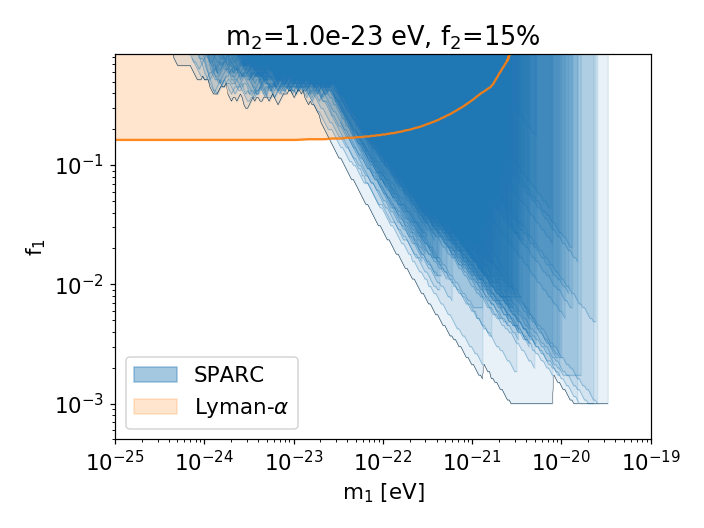

In [1286]:
plt.subplots() 
flg_label = True

f2spec_joint_arr = []
m2spec_joint_arr = []


for (galname, (m_arr, f_arr)) in f_dct.iteritems():
#     mask1 = np.where(m_arr>m_low_1, True, False)
#     mask2 = np.where(m_arr<m_up_1, True, False)
#     mask = mask1 * mask2
#     #mask = [True] * len(m_arr)
    try:
        log10mlow_sol, log10mup_sol = bound_range_dct[galname]
    except:
        continue
    mask1 = np.where(m_arr>10**log10mlow_sol.root, True, False)
    mask2 = np.where(m_arr<10**log10mup_sol.root, True, False)
    
#     # make sure there's still enough mass to make the soliton
#     Msol_arr = model.M_SH(m_arr, gal)
#     mask3 = np.where(f_arr>(Msol_arr/()), True, False)
    
    mask = mask1 * mask2    
    
    if sum(mask) > 0:
        if flg_label is True:
            plt.fill_between(m_arr[mask], f_arr[mask], 1., color='C0', alpha=0.4, interpolate='nearest', label='SPARC')        
            flg_label = False
        else:
            plt.fill_between(m_arr[mask], f_arr[mask], 1., color='C0', alpha=0.1, interpolate='nearest')        
            plt.plot(m_arr[mask], f_arr[mask], color='C0', alpha=0.6, lw='0.3')        
        m2spec_joint_arr, f2spec_joint_arr = scan.lower_array(m2spec_joint_arr, f2spec_joint_arr, m_arr[mask], f_arr[mask])

# # the SPARC boundary 
# plt.vlines(m_low_05, 0.001, 20, color='k', linestyle=':')
# plt.vlines(m_low_1, 0.001, 20, color='k', linestyle=':')
# plt.vlines(m_low_2, 0.001, 20, color='k', linestyle=':')
# plt.vlines(m_up_05, 0.001, 20, color='k', linestyle=':')
# plt.vlines(m_up_1, 0.001, 20, color='k', linestyle=':')
# plt.vlines(m_up_2, 0.001, 20, color='k', linestyle=':')


# check the edge
plt.plot(m2spec_joint_arr, f2spec_joint_arr, 'k', lw=0.2)


# overlay with Kobayashi
path = '../data/Kobayashi2017.csv'
data_lym_arr = np.loadtxt(path, delimiter=',')
x = data_lym_arr[:,0]
y = data_lym_arr[:,1]
x = np.insert(x, 0, 1e-25)
y = np.insert(y, 0, y[0])
plt.fill_between(x, y, 100, color='C1', label=r'Lyman-$\alpha$', alpha=0.2, zorder=0)
plt.plot(x, y, color='C1', alpha=0.9)
plt.legend(loc=3)

plt.xscale('log')
plt.yscale('log')
plt.ylim(0.5e-3, 1.-f2)
plt.ylabel('f$_1$')
plt.xlabel('m$_1$ [eV]')
plt.xlim(1e-25, 1e-19)
plt.title('m$_2$=%.1e eV, f$_2$=%.0f%%' %(m2, f2*100))
plt.tight_layout()
plt.savefig('./plots/f_2sigma_two_species.pdf')

In [1254]:
path = '../data/Kobayashi2017.csv'
data_lym_arr = np.loadtxt(path, delimiter=',')

In [1280]:
def func(gal, gridsize=20, bound_range_dct=bound_range_dct):
    #mask it first
    try:
        log10mlow_sol, log10mup_sol = bound_range_dct[gal.name]
    except:
        # raise Exception('Do not have a valid mass range where SH applies')
        print('Do not have a valid mass range where SH applies, gal=%s' %(gal.name))
        return ('na', None, None, None)
    mlow = 10**log10mlow_sol.root
    mup = 10**log10mup_sol.root
    
    m1_arr = np.logspace(np.log10(mlow), np.log10(mup), gridsize)
    m2_arr = np.logspace(-25, -19, gridsize)
    m1_mesh, m2_mesh = np.meshgrid(m1_arr, m2_arr, indexing='ij')
    m1_flat, m2_flat = m1_mesh.reshape(-1), m2_mesh.reshape(-1)
    f1_flat = []
    for i in range(len(m1_flat)):
        m1 = m1_flat[i]
        m2 = m2_flat[i]
        f2 = np.interp(m2, data_lym_arr[:,0], data_lym_arr[:,1], right=1)
        f1_flat.append(model.f_critical_two_species(m1, m2, f2, gal))
    f1_flat = np.array(f1_flat)
    return (gal, m1_mesh, m2_mesh, f1_flat)


gal = spc.findGalaxyByName('UGC04325', data) 
gal, m1_mesh, m2_mesh, f1_flat = func(gal, 20)

../model.py:507: RuntimeWarning: divide by zero encountered in double_scalars
  M_SH_val = M_SH(m, gal)


<IPython.core.display.Javascript object>


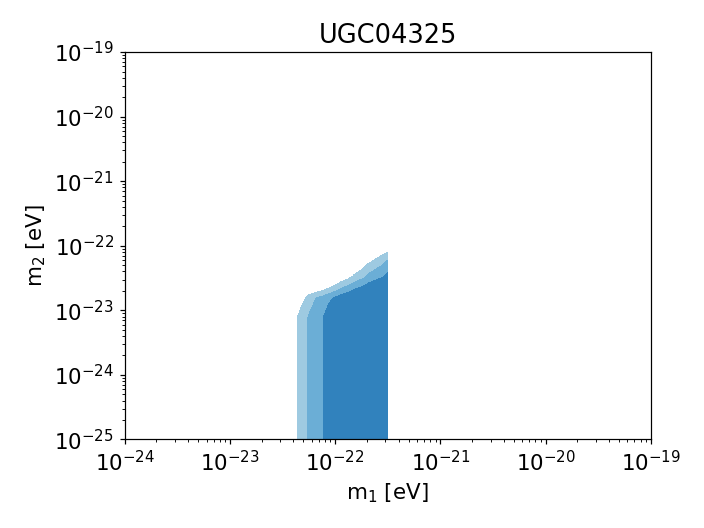

In [1282]:
cm = plt.cm.get_cmap('tab20c')
plt.subplots()
cs = plt.contourf(m1_mesh, m2_mesh, f1_flat.reshape(m1_mesh.shape), levels=[0, 0.1, 0.15, 0.2], colors=[cm.colors[0], cm.colors[1], cm.colors[2]]) # cmap=plt.cm.Blues_r)
#plt.colorbar(cs, format='%2.1f')
#cs = plt.contour(m1_mesh, m2_mesh, f1_flat.reshape(m1_mesh.shape), levels=[0.1], colors=['C0'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('m$_1$ [eV]')
plt.ylabel('m$_2$ [eV]')
plt.xlim(1e-24, 1e-19)
plt.ylim(1e-25, 1e-19)
plt.title('%s' %(gal.name))
plt.tight_layout()
plt.savefig('./plots/m1_m2_f1_single_gal_%s.pdf' %(gal.name))

In [1257]:
f2d_dct = {}
with closing(Pool()) as pool:
    res = pool.map(func, data)
    for gal, m1_mesh, m2_mesh, f1_flat in res:
        if gal == "na":
            pass
        else:
            f2d_dct[gal.name] = (m1_mesh, m2_mesh, f1_flat.reshape(m1_mesh.shape))
    pool.terminate()

Do not have a valid mass range where SH applies, gal=CamB
Do not have a valid mass range where SH applies, gal=D631-7


../model.py:507: RuntimeWarning: divide by zero encountered in double_scalars
  M_SH_val = M_SH(m, gal)
../model.py:507: RuntimeWarning: divide by zero encountered in double_scalars
  M_SH_val = M_SH(m, gal)
../model.py:507: RuntimeWarning: divide by zero encountered in double_scalars
  M_SH_val = M_SH(m, gal)
../model.py:507: RuntimeWarning: divide by zero encountered in double_scalars
  M_SH_val = M_SH(m, gal)
../model.py:507: RuntimeWarning: divide by zero encountered in double_scalars
  M_SH_val = M_SH(m, gal)


Do not have a valid mass range where SH applies, gal=NGC6674


../model.py:507: RuntimeWarning: divide by zero encountered in double_scalars
  M_SH_val = M_SH(m, gal)
../model.py:507: RuntimeWarning: divide by zero encountered in double_scalars
  M_SH_val = M_SH(m, gal)


Do not have a valid mass range where SH applies, gal=UGC02487


../model.py:507: RuntimeWarning: divide by zero encountered in double_scalars
  M_SH_val = M_SH(m, gal)
../model.py:507: RuntimeWarning: divide by zero encountered in double_scalars
  M_SH_val = M_SH(m, gal)


Do not have a valid mass range where SH applies, gal=UGC09133


../model.py:507: RuntimeWarning: divide by zero encountered in double_scalars
  M_SH_val = M_SH(m, gal)
../model.py:507: RuntimeWarning: divide by zero encountered in double_scalars
  M_SH_val = M_SH(m, gal)


In [1258]:
# z = np.arange(20).reshape(5, 4)
# mask = np.zeros(z.shape, dtype=bool)

# mask[3, 2] = True

# zm = np.ma.masked_array(z, mask)
# print z
# print zm
# zm[3, 2]

<IPython.core.display.Javascript object>


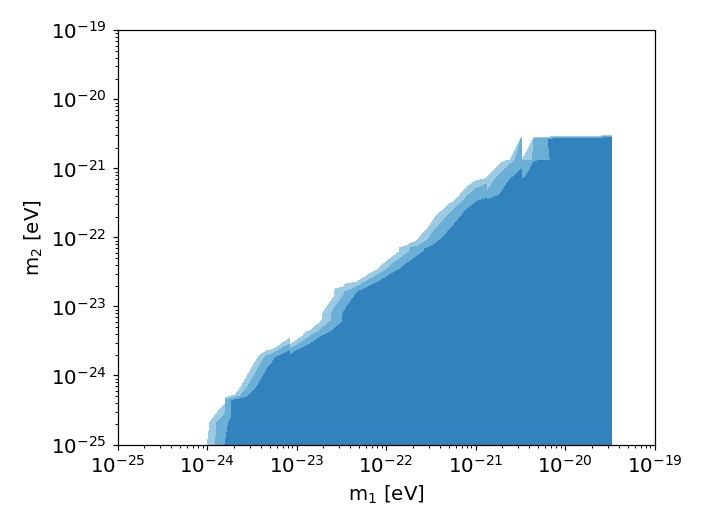

In [1262]:
plt.subplots()
cm = plt.cm.get_cmap('tab20c')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('m$_1$ [eV]')
plt.ylabel('m$_2$ [eV]')
plt.xlim(1e-25, 1e-19)
plt.ylim(1e-25, 1e-19)

#plt.xlim(1e-24, 1e-19)
#plt.ylim(1e-25, 2e-21)

for (galname, (m1_mesh, m2_mesh, f1_mesh)) in f2d_dct.iteritems():
    try:
        log10mlow_sol, log10mup_sol = bound_range_dct[galname]
    except:
        continue
    mlow = 10**log10mlow_sol.root
    mup = 10**log10mup_sol.root
    
    ## mask is moved into func() def
    # mask1 = np.where(m1_mesh > mlow, True, False)
    # mask2 = np.where(m1_mesh < mup, True, False)
    # mask = np.logical_not(mask1 * mask2)
    # f1_masked = np.ma.masked_array(f1_mesh, mask)
    
    f1_masked = f1_mesh
    cs = plt.contourf(m1_mesh, m2_mesh, f1_masked, levels=[0.15, 0.2], colors=[cm.colors[2]], alpha=1, zorder=0.9)
    cs = plt.contourf(m1_mesh, m2_mesh, f1_masked, levels=[0.1, 0.15], colors=[cm.colors[1]], alpha=1, zorder=1)
    cs = plt.contourf(m1_mesh, m2_mesh, f1_masked, levels=[0, 0.1], colors=[cm.colors[0]], alpha=1, zorder=1.1)
    
plt.tight_layout()
plt.savefig('./plots/m1_m2_f1_SPARC.pdf')

In [28]:
gal.__dict__.keys()

['c',
 'name',
 'rs',
 'Vdisk',
 'SBbul',
 'Vflat',
 'R',
 'dVobs',
 'Vbul',
 'Vobs',
 'dVflat',
 'Vgas',
 'SBdisk',
 'D']

In [30]:
model.reconstruct_mass_total(gal)

array([1.17153920e+06, 3.26720265e+06, 6.28925582e+06, 1.05029484e+07,
       1.50000602e+07, 2.17250934e+07, 3.27361968e+07, 4.72252655e+07,
       7.21018455e+07, 8.24416477e+07, 1.04764828e+08, 1.25603068e+08,
       1.34269371e+08, 1.54774693e+08, 1.66500668e+08, 1.85597473e+08,
       2.08842381e+08, 2.27099298e+08, 2.66247581e+08, 2.87397489e+08,
       3.33046163e+08, 3.57307404e+08, 3.65520679e+08, 4.43089539e+08,
       4.38416331e+08, 4.78157493e+08, 5.35727582e+08, 5.04070099e+08,
       5.57144472e+08, 5.81705385e+08, 6.40007203e+08, 7.05985682e+08,
       7.72187363e+08, 8.15178918e+08, 7.51390578e+08, 8.93561416e+08])

In [32]:
mass_fn, _, _ = model.reconstruct_mass_DM(gal)
mass_fn(gal.R)

array([1.42882124e+06, 3.57780634e+06, 6.69192321e+06, 1.07678045e+07,
       1.58020961e+07, 2.17914569e+07, 2.98016448e+07, 3.78263930e+07,
       4.67957949e+07, 5.67065633e+07, 6.75554238e+07, 7.93391148e+07,
       9.20543873e+07, 1.05698005e+08, 1.20266744e+08, 1.38045415e+08,
       1.54585760e+08, 1.72041177e+08, 1.90408492e+08, 2.12512269e+08,
       2.32823029e+08, 2.54035799e+08, 2.76147456e+08, 2.95813389e+08,
       3.23055007e+08, 3.47844719e+08, 3.73520951e+08, 4.00080644e+08,
       4.27520746e+08, 4.59955018e+08, 4.89271497e+08, 5.19458875e+08,
       5.50514152e+08, 5.87064794e+08, 6.19969799e+08, 6.53733343e+08])

In [34]:
gal.name

'UGCA444'

In [35]:
data2

{'CamB': <spc.Galaxy at 0x7fc7a93bffd0>,
 'D512-2': <spc.Galaxy at 0x7fc7a93bff90>,
 'D564-8': <spc.Galaxy at 0x7fc7a93600d0>,
 'D631-7': <spc.Galaxy at 0x7fc7a9360090>,
 'DDO064': <spc.Galaxy at 0x7fc7d8a4aa10>,
 'DDO154': <spc.Galaxy at 0x7fc7a9360150>,
 'DDO161': <spc.Galaxy at 0x7fc7a9360190>,
 'DDO168': <spc.Galaxy at 0x7fc7a93601d0>,
 'DDO170': <spc.Galaxy at 0x7fc7a9360210>,
 'ESO079-G014': <spc.Galaxy at 0x7fc7a9360250>,
 'ESO116-G012': <spc.Galaxy at 0x7fc7a9360290>,
 'ESO444-G084': <spc.Galaxy at 0x7fc7a93602d0>,
 'ESO563-G021': <spc.Galaxy at 0x7fc7a9360310>,
 'F561-1': <spc.Galaxy at 0x7fc7a9360350>,
 'F563-1': <spc.Galaxy at 0x7fc7a9360390>,
 'F563-V1': <spc.Galaxy at 0x7fc7a93603d0>,
 'F563-V2': <spc.Galaxy at 0x7fc7a9360410>,
 'F565-V2': <spc.Galaxy at 0x7fc7a9360450>,
 'F567-2': <spc.Galaxy at 0x7fc7a9360490>,
 'F568-1': <spc.Galaxy at 0x7fc7a93604d0>,
 'F568-3': <spc.Galaxy at 0x7fc7a9360510>,
 'F568-V1': <spc.Galaxy at 0x7fc7a9360550>,
 'F571-8': <spc.Galaxy at 0x7fc7

In [ ]:
tau_dct = {}

<IPython.core.display.Javascript object>


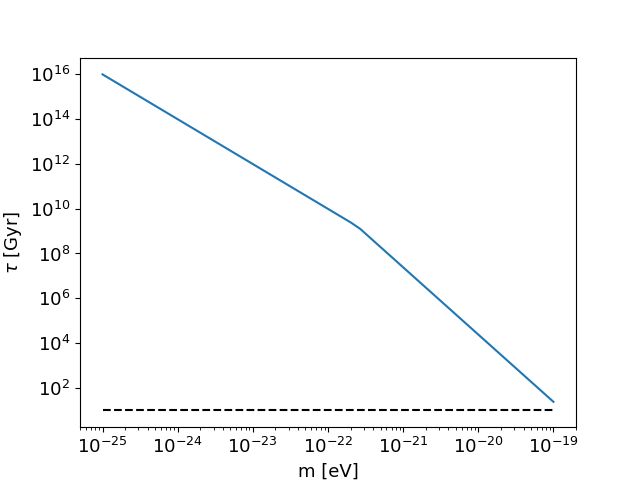

Text(0,0.5,'$\\tau$ [Gyr]')

In [47]:
#gal = data2['UGCA444']
gal = data2['UGC04325']
m_arr = np.logspace(-25, -19)
tau_arr = model.tau_BH(m_arr, gal, 4e6)
tau_dct[gal.name] = tau_arr

plt.subplots()
plt.plot(m_arr, tau_arr)
plt.plot(m_arr, [10]*len(m_arr), 'k--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel(r'$\tau$ [Gyr]')


In [66]:
# runtime wrapper
MBH = 1e8 # 4e6
m_arr = np.logspace(-25, -19)
tau_dct = {}

def func(gal):    
    tau_arr = model.tau_BH(m_arr, gal, MBH)
    return gal, tau_arr

with closing(Pool()) as pool:
    res = pool.map(func, data)
    for gal, tau_arr in res:
        tau_dct[gal.name] = tau_arr
    pool.terminate()

<IPython.core.display.Javascript object>


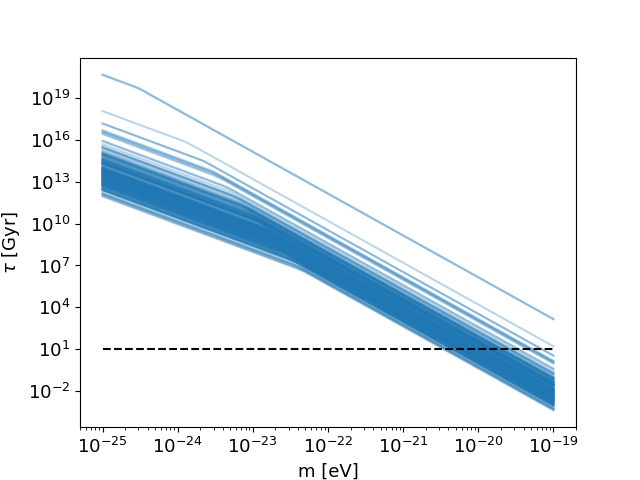

Text(0,0.5,'$\\tau$ [Gyr]')

In [67]:
plt.subplots()
for tau_arr in tau_dct.itervalues():
    #tau_arr = tau_dct[gal.name]
    plt.plot(m_arr, tau_arr, 'C0', alpha=0.3)
    
plt.plot(m_arr, [10]*len(m_arr), 'k--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel(r'$\tau$ [Gyr]')